In [106]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Conv2D,MaxPool2D,Flatten,BatchNormalization, Input, Layer,Dropout, GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, Concatenate, Activation, Add, ReLU, LeakyReLU, PReLU, ELU, Softmax, ZeroPadding2D, UpSampling2D, Conv2DTranspose, Reshape, Lambda, Multiply, Dot, Permute, LSTM, Bidirectional, GRU, TimeDistributed, ConvLSTM2D, BatchNormalization, LayerNormalization, GaussianNoise, GaussianDropout, Embedding, RepeatVector, Attention, AdditiveAttention, MultiHeadAttention, LayerNormalization, GaussianNoise, GaussianDropout, Embedding, RepeatVector, Attention, AdditiveAttention, MultiHeadAttention, Dropout,RandomFlip,RandomRotation,RandomZoom,RandomTranslation,RandomCrop,Rescaling,CenterCrop,Normalization,Resizing
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryAccuracy, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall,AUC
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow.keras.regularizers import L1, L2 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback ,CSVLogger, LearningRateScheduler
import sklearn
from sklearn.metrics import confusion_matrix, classification_report,roc_curve
import albumentations as A


## Data Prep

In [123]:
dataset,dataset_info=tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

In [124]:
def splits(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):

    DATASET_SIZE=len(dataset)
    train_dataset=dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    val_test_dataset=dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset=val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset=val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset,val_dataset,test_dataset

In [125]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [126]:
TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1
train_dataset, val_dataset, test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


In [127]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\nagra\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin 

## Data Visualization

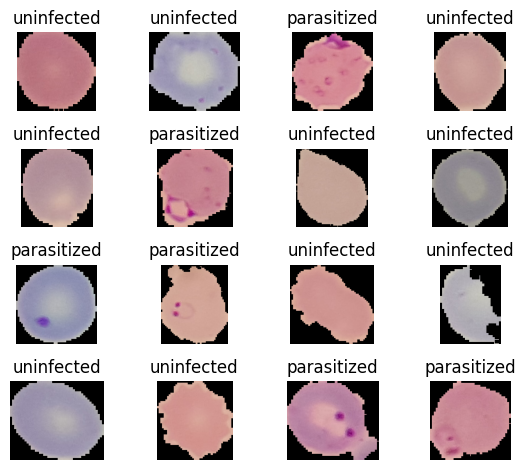

In [128]:
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')
    plt.tight_layout()

In [129]:
dataset_info.features['label'].int2str(0)

'parasitized'

## Data Pre-Processing

### Augmentation

In [130]:
def visualize(image,augmented_image):
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(augmented_image)

In [131]:
original_image,label=next(iter(train_dataset))

In [132]:
augmented_image=tf.image.flip_up_down(original_image)

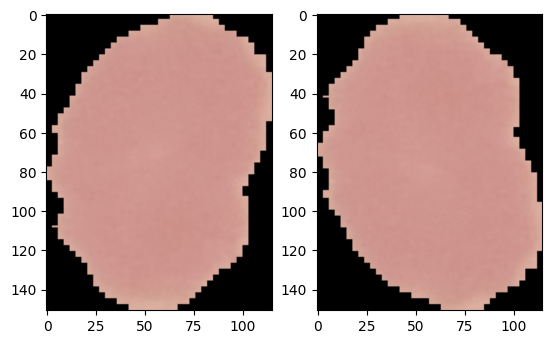

In [133]:
visualize(original_image,augmented_image)

In [12]:
# Standardize or Normalize the images? Read how o decide! 

In [134]:
IMSIZE=224
def resize_rescale(image,label):
    return tf.image.resize(image,(IMSIZE,IMSIZE))/255.0, label

In [135]:
### using tf.image functions
@tf.function
def augment(image,label):
    image,label=resize_rescale(image,label)
    image=tf.image.rot90(image,k=tf.random.uniform(shape=[],minval=0,maxval=2,dtype=tf.int32))
    # image=tf.image.adjust_saturation(image,0.3)
    # image=tf.image.random_flip_left_right(image)
    image = tf.image.stateless_random_flip_left_right(image)
    return image,label

In [83]:
class Rot90(Layer):
    def __init__(self):
        super(Rot90,self).__init__()
    def call(self,inputs):
        return tf.image.rot90(inputs,k=tf.random.uniform(shape=[],minval=0,maxval=2,dtype=tf.int32))   

In [16]:
### using tf.keras.layers
resize_rescale_layers=tf.keras.Sequential([
    Resizing(IMSIZE,IMSIZE),
    Rescaling(1.0/255.0)
])


In [17]:
### using tf.keras.layers
augment_layers=tf.keras.Sequential([
    Rot90(),
    RandomRotation(factor=(0.25,0.2501)),
    # RandomZoom(0.2)
])
def augment_layer(image,labels):
    return augment_layers(resize_rescale_layers(image),training=True),labels

In [18]:
###### test_dataset=test_dataset.map(resize_rescale_layers)

In [320]:
for image,label in train_dataset.take(1):
    print(image)
    print(label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(145, 148, 3), dtype=uint8)
tf.Tensor(1, shape=(), dtype=int64)


In [321]:
train_dataset=(
    train_dataset
    .shuffle(buffer_size=8,reshuffle_each_iteration=True)
    ####.map(augment_layer)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)

In [120]:
val_dataset=(
    val_dataset
    .shuffle(buffer_size=8,reshuffle_each_iteration=True)
    ####.map(resize_rescale_layers)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)

In [136]:
droupout_rate=0.2

### Mixup Data Augmentation

In [403]:
train_dataset1=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resize_rescale)
train_dataset2=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resize_rescale)
mixed_dataset=tf.data.Dataset.zip((train_dataset1,train_dataset2))

In [404]:
def mixup(train_dataset_1,train_dataset_2,alpha=0.2):
    image_1,label_1=train_dataset_1
    image_2,label_2=train_dataset_2
    l=tfp.distributions.Beta(0.2,0.2).sample(1)[0]
    image=l*image_1+(1-l)*image_2
    label=l*tf.cast(label_1,dtype=tf.float32)+(1-l)*tf.cast(label_2,dtype=tf.float32)
    return image,label

In [137]:
BATCH_SIZE=32


In [405]:
train_dataset=(
    mixed_dataset
    .shuffle(buffer_size=8,reshuffle_each_iteration=True)
    # .map(mixup)
    .map(cutmix)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [406]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [138]:
val_dataset=(
    val_dataset
    .map(resize_rescale)
    .batch(BATCH_SIZE)
)

In [357]:
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### CutMix augmentation

In [358]:
IMSIZE=224

In [407]:
def box(l):
    r_x=tf.cast(tfp.distributions.Uniform(0,IMSIZE).sample(1)[0],dtype=tf.int32)
    r_y=tf.cast(tfp.distributions.Uniform(0,IMSIZE).sample(1)[0],dtype=tf.int32)
    r_w=tf.cast(IMSIZE*tf.math.sqrt(1-l),dtype=tf.int32)
    r_h=tf.cast(IMSIZE*tf.math.sqrt(1-l),dtype=tf.int32)

    r_x=tf.clip_by_value(r_x-r_w//2,0,IMSIZE)
    r_y=tf.clip_by_value(r_y-r_h//2,0,IMSIZE)

    x_b_r=tf.clip_by_value(r_x+r_w//2,0,IMSIZE)
    y_b_r=tf.clip_by_value(r_y+r_h//2,0,IMSIZE)
    r_w=x_b_r-r_x
    if(r_w==0):
        r_w=1
    r_h=y_b_r-r_y
    if(r_h==0):
        r_h=1
    return r_y,r_x,r_h,r_w


In [408]:
def cutmix(train_dataset_1,train_dataset_2):
    (image_1,label_1),(image_2,label_2)=train_dataset_1,train_dataset_2 
    l=tfp.distributions.Beta(0.2,0.2).sample(1)[0]
    r_y,r_x,r_h,r_w=box(l)
    crop_2=tf.image.crop_to_bounding_box(image_2,r_y,r_x,r_h,r_w)
    pad_2=tf.image.pad_to_bounding_box(crop_2,r_y,r_x,224,224)
    crop_1=tf.image.crop_to_bounding_box(image_1,r_y,r_x,r_h,r_w)
    pad_1=tf.image.pad_to_bounding_box(crop_1,r_y,r_x,224,224)
    image=image_1-pad_1+pad_2
    l=tf.cast(1-(r_w*r_h)/(224*224),dtype=tf.float32)
    label=l*tf.cast(label_1,dtype=tf.float32)+(1-l)*tf.cast(label_2,dtype=tf.float32)
    return image,label

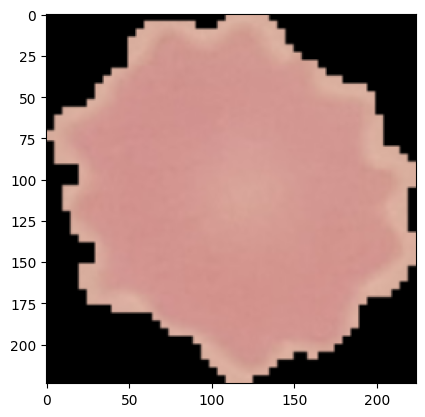

In [388]:
original_image,label=next(iter(train_dataset))
plt.imshow(original_image[0])

### Albumentations

In [139]:
transforms=A.Compose([
                        A.Resize(IMSIZE,IMSIZE),
                        A.OneOf([A.HorizontalFlip(),A.VerticalFlip(),],p=0.3),
                        A.RandomRotate90(),
                        # A.RandomGridShuffle(grid=(2,2)),
                        # A.Transpose(),
                        # A.Sharpen(),
                        # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
                        A.RandomBrightnessContrast(p=0.2),
                        A.Cutout(),
                        # A.Normalize(),
                        ])
                        

In [140]:
def aug_alby(image):
    data={"image":image}
    aug_image=transforms(**data)["image"]
    aug_image=tf.cast(aug_image/255.,dtype=tf.float32)
    return aug_image

In [141]:
def process_data(image,label):
    aug_image=tf.numpy_function(func=aug_alby,inp=[image],Tout=tf.float32)
    return aug_image,label

In [142]:
train_dataset=(
    train_dataset
    .shuffle(buffer_size=1024,reshuffle_each_iteration=True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

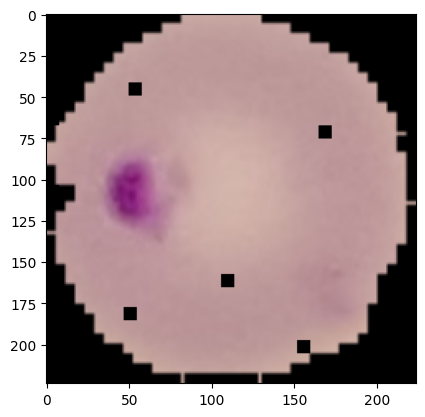

In [143]:
im,label=next(iter(train_dataset))
plt.imshow(im[1])

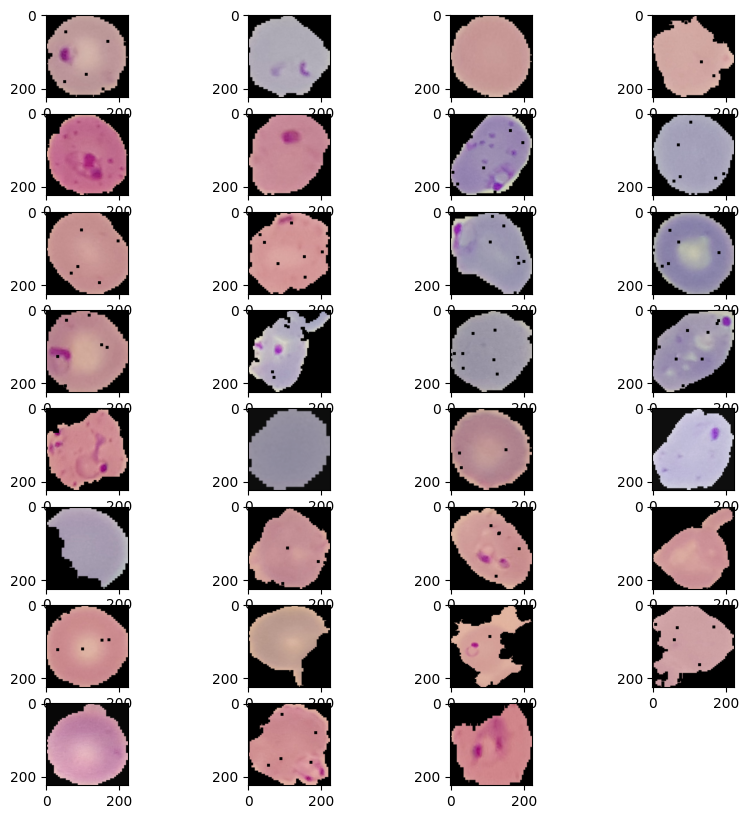

In [144]:
plt.figure(figsize=(10,10))

for i in range(1,32):
    plt.subplot(8,4,i)
    plt.imshow(im[i])

## Sequential Model

In [145]:
#LeNet
model=tf.keras.Sequential([InputLayer(input_shape=(None,None,3)),
                           resize_rescale_layers,
                           augment_layers,
                           Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
                           BatchNormalization(),
                           MaxPool2D(pool_size=2,strides=2),
                           Dropout(droupout_rate),
                           Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
                           BatchNormalization(),

                           MaxPool2D(pool_size=2,strides=2),
                           Dropout(droupout_rate),

                           Flatten(),

                           Dense(100,activation="relu",kernel_regularizer=L2(0.01)),
                           BatchNormalization(),
                           Dropout(droupout_rate),

                           Dense(10,activation="relu",  kernel_regularizer=L2(0.01)),
                           BatchNormalization(),
                           Dense(1,activation="sigmoid",  kernel_regularizer=L2(0.01)),

                           
                           ])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_5 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 111, 111, 6)      

## Functional API

In [89]:
func_input = Input(shape=(IMSIZE,IMSIZE,3), name='Input Image')
x=Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu')(func_input)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=2,strides=2)(x)

x=Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu')(x)
x=BatchNormalization()(x)
output=MaxPool2D(pool_size=2,strides=2)(x)
lenet_model_extrator=Model(inputs=func_input,outputs=output,name='LeNet_Extractor')
lenet_model_extrator.summary()

Model: "LeNet_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 


 conv2d_14 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_28 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_29 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 16)       0         
 g2D)                                                            
          

In [90]:
func_input = Input(shape=(IMSIZE,IMSIZE,3), name='Input Image')
x=lenet_model_extrator(func_input)
x=Flatten()(x)
x=Dense(100,activation="relu")(x)
x=BatchNormalization()(x)
x=Dense(10,activation="relu")(x)
x=BatchNormalization()(x)
func_output=Dense(1,activation="sigmoid")(x)
model=Model(inputs=func_input, outputs=func_output, name='LeNet')
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 LeNet_Extractor (Functional  (None, 54, 54, 16)       1136      
 )                                                               
                                                                 
 flatten_7 (Flatten)         (None, 46656)             0         
                                                                 
 dense_18 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_30 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 10)                1010  

## Model Subclassing

In [91]:
class FeatureExtractor(Layer):
    def __init__(self, filters,kernel_size,strides,padding,activation,pool_size,**kwargs):
        super(FeatureExtractor, self).__init__(**kwargs)
        self.conv1 = Conv2D(filters = filters,kernel_size = kernel_size,strides = strides,padding = padding,activation=activation)
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPool2D(pool_size=pool_size,strides=2*strides)
        self.conv2 = Conv2D(filters=filters*2,kernel_size=kernel_size,strides=strides,padding=padding,activation=activation)
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPool2D(pool_size=pool_size,strides=2*strides)
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return self.pool2(x)

feature_extractor = FeatureExtractor(8,3,1,'valid','relu',2,name='Feature_Extractor')

In [92]:
func_input = Input(shape=(IMSIZE,IMSIZE,3), name='Input Image')
x=feature_extractor(func_input)
x=Flatten()(x)
x=Dense(100,activation="relu")(x)
x=BatchNormalization()(x)
x=Dense(10,activation="relu")(x)
x=BatchNormalization()(x)
func_output=Dense(1,activation="sigmoid")(x)
model=Model(inputs=func_input, outputs=func_output, name='LeNet')
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten_8 (Flatten)         (None, 46656)             0         
                                                                 
 dense_21 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_34 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_22 (Dense)            (None, 10)                1010  

In [93]:
class Lenet(Model):
    def __init__(self,**kwargs):
        super(Lenet, self).__init__(**kwargs)
        self.feature_extractor=FeatureExtractor(8,3,1,'valid','relu',2,name='Feature_Extractor')
        self.flatten=Flatten()
        self.dense1=Dense(100,activation="relu")
        self.bn1=BatchNormalization()
        self.dense2=Dense(10,activation="relu")
        self.bn2=BatchNormalization()
        self.dense3=Dense(1,activation="sigmoid")

    def call(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn1(x)
        x = self.dense2(x)
        x = self.bn2(x)
        return self.dense3(x)
  

Lenet_Model = Lenet()
Lenet_Model(tf.zeros((1, IMSIZE, IMSIZE, 3)))
Lenet_Model.summary()

Model: "lenet_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extractor (FeatureE  multiple                 1488      
 xtractor)                                                       
                                                                 
 flatten_9 (Flatten)         multiple                  0         
                                                                 
 dense_24 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_38 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_39 (Bat  multiple                 40  

## Custom Layers

In [94]:
class CustomDense(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(CustomDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)
    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b) 

In [95]:
#LeNet
model=tf.keras.Sequential([InputLayer(input_shape=(IMSIZE,IMSIZE,3)),
                           Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
                           BatchNormalization(),
                           MaxPool2D(pool_size=2,strides=2),

                           Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu'),
                           BatchNormalization(),

                           MaxPool2D(pool_size=2,strides=2),

                           Flatten(),

                           CustomDense(100,activation="relu"),
                           BatchNormalization(),
                           CustomDense(10,activation="relu"),
                           BatchNormalization(),
                           CustomDense(1,activation="sigmoid"),

                           
                           ])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_40 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_41 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

## Callbacks

In [146]:
class LossCallback(Callback):
    def __init__(self, threshold):
        super(LossCallback, self).__init__()
        self.threshold = threshold
    def on_epoch_end(self, epoch, logs=None):
        if logs["loss"] < self.threshold:
            print(f"\nEpoch {epoch}: Reached loss less than {self.threshold}, stopping training")
            self.model.stop_training = True
    def on_batch_end(self, batch, logs=None):
            print(f"\nBatch {batch}: Reached loss after this batch is {logs}")
            

## CSVLogger

In [147]:
csv_callback=CSVLogger(
    'logs.csv', separator=",", append=True
)


## EarlyStopping

In [148]:
es_callback=EarlyStopping( 
    monitor='val_loss', 
    min_delta=0,
    patience=2, 
    verbose=1, 
    mode='auto', 
    restore_best_weights=False
)

## LR Scheduling

In [149]:
def scheduler(epoch,lr):
    if epoch<10:
        return lr
    else:
        return lr*tf.math.exp(-0.1)
scheduler_callback=LearningRateScheduler(scheduler,verbose=1)

## ReduceLRonPlateau

In [150]:
plateau_callback=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1, 
    patience=2, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001, 
    cooldown=0, 
    min_lr=0
)

## Model Checkpoint

In [151]:
checkpoint_callback=ModelCheckpoint(
    'model_checkpoint', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True,
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch'
)

## Model Training

In [152]:
#Binary Croos ENtropy Loss
y_true=[0,1,0,0]
y_pred=[0.6,0.51,0.94,1]
bce=tf.keras.losses.BinaryCrossentropy()
bce(y_true,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [153]:
metrics=[TruePositives(name='tp'),FalsePositives(name='fp'),TrueNegatives(name='tn'),FalseNegatives(name='fn'),BinaryAccuracy(name='accuracy'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

In [154]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=metrics)
            

In [155]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1471820297940556664
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11393612444795823752
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [156]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1,callbacks=[plateau_callback,checkpoint_callback,scheduler_callback,csv_callback,es_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/20


689/689 [==============================] - ETA: 0s - loss: 4.5196 - tp: 6854.0000 - fp: 4456.0000 - tn: 6563.0000 - fn: 4173.0000 - accuracy: 0.6086 - precision: 0.6060 - recall: 0.6216 - auc: 0.6486
Epoch 1: val_loss improved from inf to 8.27506, saving model to model_checkpoint
689/689 [==============================] - 124s 176ms/step - loss: 4.5196 - tp: 6854.0000 - fp: 4456.0000 - tn: 6563.0000 - fn: 4173.0000 - accuracy: 0.6086 - precision: 0.6060 - recall: 0.6216 - auc: 0.6486 - val_loss: 8.2751 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1360.0000 - val_fn: 1395.0000 - val_accuracy: 0.4936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6687 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/20
689/689 [==============================] - ETA: 0s - loss: 4.9399 - tp: 7285.0000 - fp: 4324.0000 - tn: 6695.0000 - fn: 3742.0000 - accuracy: 0.6341 - precision: 0.6275 - recall: 0.6607 - auc: 0.6745
Epoch 2: val_

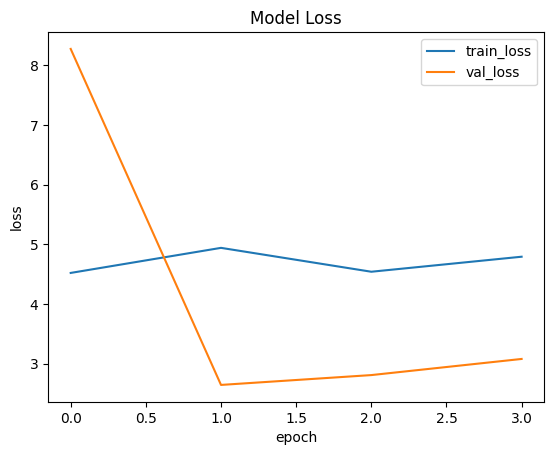

In [157]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

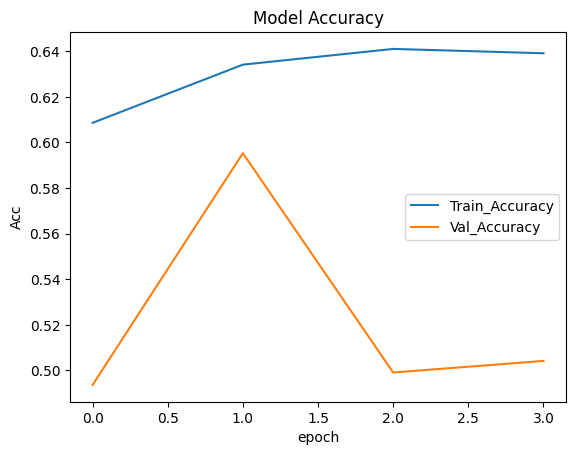

In [158]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['Train_Accuracy','Val_Accuracy'])
plt.show()

## Model Eval and Testing

In [21]:
test_dataset=test_dataset.batch(1)

In [29]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 22s 7ms/step - loss: 0.2700 - tp: 1244.0000 - fp: 89.0000 - tn: 1308.0000 - fn: 116.0000 - accuracy: 0.9256 - precision: 0.9332 - recall: 0.9147 - auc: 0.9692


[0.2700253129005432,
 1244.0,
 89.0,
 1308.0,
 116.0,
 0.925643801689148,
 0.9332333207130432,
 0.9147058725357056,
 0.9692308306694031]

In [41]:
Lenet_Model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 2s 2s/step


0.9981134

In [42]:
def parasite_or_not(x):
    if(x<0.5):
        return str('P')
    else:
        return str('U')

In [43]:
parasite_or_not(Lenet_Model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 2s 2s/step


'U'

1/1 [==============================] - 0s 20ms/step


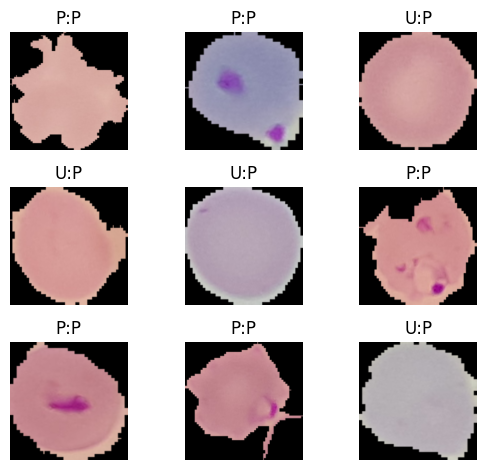

In [44]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0]))+":"+str(parasite_or_not(model.predict(image)[0][0])))
    plt.axis('off')
    plt.tight_layout()

### Confusion Matrix

In [40]:
labels=[]
inp=[]
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [34]:
print(labels)

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64),

In [39]:
labels=np.array([i[0] for i in labels])
print(labels)

[1 1 0 ... 1 0 0]


In [41]:
print(np.array(inp).shape)

(2757, 1, 224, 224, 3)


In [42]:
predicted = Lenet_Model.predict(np.array(inp)[:,0,:,:,:])

87/87 [==============================] - 4s 23ms/step


In [45]:
print(predicted[:,0])

[0.00564024 0.00169924 0.9661768  ... 0.965968   0.02233901 0.98552066]


[[1335   64]
 [ 117 1241]]


Text(0.5, 25.722222222222214, 'Predicted label')

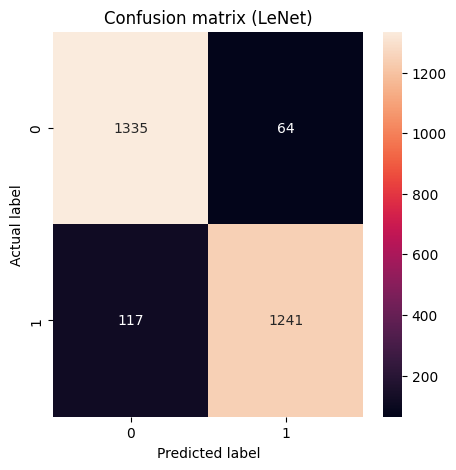

In [59]:
threshold=0.83
cm=confusion_matrix(labels,predicted[:,0]>threshold)
print(cm)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,fmt="d")
plt.title("Confusion matrix (LeNet)")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

### ROC Curves

In [51]:
fp, tp, th = roc_curve(labels, predicted[:,0])
print(len(fp),len(tp),len(th))

230 230 230


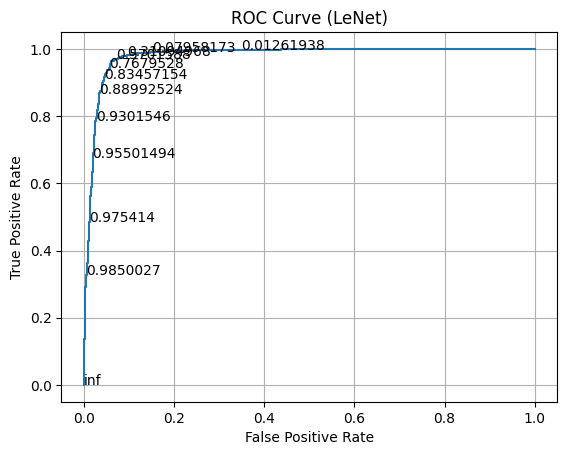

<Figure size 640x480 with 0 Axes>

In [58]:
plt.plot(fp,tp)
plt.title("ROC Curve (LeNet)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
for i in range(0,len(fp),20):
    plt.text(fp[i],tp[i],th[i])
plt.grid(True)
plt.show()
plt.tight_layout()